In [31]:
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
from tqdm import tqdm
import pdb
import limix
import pickle as pkl
import numpy as np
import seaborn as sns
from numpy import asarray
import xarray as xr
from copy import deepcopy
import os
from os.path import join
import simplejson as json
import hashlib
import pandas as pd
import pdb
from glob import glob
import h5py
import re
from plot import plot_poisson_ordered, plot_distplots, plot_distplot
from util import get_amelie_selection
import h5py
import dask
import dask.dataframe
import dask.array
from adjustText import adjust_text
from urllib.request import urlopen
from joblib import Parallel, delayed
import gzip
try:
    import ipfsapi
    has_ipfs = True
except ModuleNotFoundError:
    has_ipfs = False


if has_ipfs:
    try:
        ipfs = ipfsapi.connect('127.0.0.1', 5001)
    except Exception:
        has_ipfs = False

only_hash = True

# Load data (Amelie's and Hannah's)

In [32]:
if os.path.exists("data/traits-kinship-hannah-amelie.pkl"):
    data = pkl.load(open("data/traits-kinship-hannah-amelie.pkl", "rb"))
else:
    url = "http://ipfs.io/ipfs/QmXtFuoA3JTkhhpUpqh4dyu3FJLUG7DWAmXwUk1N2TMbAh"
    data = pkl.load(urlopen(url))
    
dst_folder = "3"
if not os.path.exists(dst_folder):
    os.mkdir(dst_folder)
if not os.path.exists(join(dst_folder, 'phenotype')):
    os.mkdir(join(dst_folder, 'phenotype'))
if not os.path.exists(join(dst_folder, 'kinship')):
    os.mkdir(join(dst_folder, 'kinship'))

In [33]:
def isbernoulli(x):
    x = np.asarray(x, float)
    u = np.unique(x)
    if len(u) == 2:
        return True
    return False

def get_bernoulli(x):
    x = np.asarray(x, float)
    u = np.unique(x)
    i0 = x == u[0]
    i1 = x == u[1]
    x[i0] = 0.0
    x[i1] = 1.0
    return x

def isdiscrete(x):
    x = np.asarray(x, float)
    ok = np.isfinite(x)
    return all(x[ok] == np.asarray(x[ok], int))

def get_poisson(x):
    x = np.asarray(x, float)
    mi = min(x)    
    if mi < 0:
        x += -mi
    return x

def isnumber(x):
    try:
        np.asarray(x, float)
    except ValueError:
        return False
    return True

In [34]:
f = h5py.File("arrayexpress/HS.hdf5", "r")
samples = np.asarray(f["/imputed_genotypes/row_header/rat"].value)
samples = [i.decode() for i in samples]
f.close()

In [35]:
data0 = deepcopy(data)
remove = []
for name in data0['measures'].columns.values:
    ok0 = isnumber(data0['measures'].loc[:, name])
    if ok0 and isdiscrete(data0['measures'].loc[:, name]):
        data0['measures'].loc[:, name] = get_poisson(data0['measures'].loc[:, name])
    else:
        remove.append(name)
for name in remove:
    del data0['measures'][name]

In [38]:
data["measures"]["time_freezing"].dropna().shape

(1335,)

/nfs/software/stegle/users/horta/conda-envs/lab/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


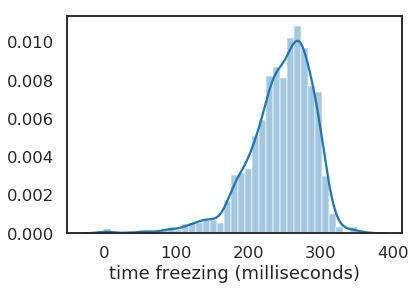

In [29]:
sns.set_style("white")
sns.set_context("talk")
sns.distplot(data["measures"]["time_freezing"].dropna(), norm_hist=True)
plt.xlabel("time freezing (milliseconds)")
plt.savefig("time_freezing.pdf", bbox_inches='tight')

In [30]:
plt.close()

In [39]:
f = h5py.File("arrayexpress/HS.hdf5", "r")
pos = []
chrs = []
for i in tqdm(range(1, 22)):
    p = f["/imputed_genotypes/chr{}/col_header/pos".format(i)].value
    pos.append(p)
    chrs.append([i] * len(p))
f.close()

pos = np.concatenate(pos).astype(float)
chrs = np.concatenate(chrs).astype(int)

100%|██████████| 21/21 [00:00<00:00, 358.88it/s]


In [40]:
amelie_selection = get_amelie_selection()

In [ ]:
# patts = ["scan_measures_normal_(.*)_quantile_gaussianize.json.pkl",
#          "scan_measures_normal_(.*)_mean_standardize.json.pkl",
#          "scan_ipheno_normal_(.*)_mean_standardize.json.pkl",
#          "scan_ipheno_normal_(.*)_quantile_gaussianize.json.pkl",
#          "scan_measures_poisson_(.*).json.pkl"]

patts = ["scan_measures_normal_(.*)_quantile_gaussianize.json.pkl",
         "scan_measures_poisson_(.*).json.pkl"]

patt2name = {'scan_ipheno_normal_(.*)_mean_standardize.json.pkl':'INormalStd',
             'scan_ipheno_normal_(.*)_quantile_gaussianize.json.pkl':'INormalGau',
             'scan_measures_poisson_(.*).json.pkl':'MPoisson',
             'scan_measures_normal_(.*)_mean_standardize.json.pkl':'MNormalStd',
             'scan_measures_normal_(.*)_quantile_gaussianize.json.pkl':'MNormalGau'}

def plot_this(d):
    trait = d[0]["trait"]
    if trait != "time_freezing":
        return
    pos = d[0]["pos"]
    chrs = d[0]["chrs"]
    amelie_selection = d[0]["amelie_selection"]
    
    data = {}
    pv_min = np.inf
    for i, di in enumerate(d):
        with gzip.open(open(di["path"], "rb")) as f:
            data[di["model"]] = pkl.load(f)
        pv_min = min(pv_min, np.min(data[di["model"]]["pv"]))
    
    log_pv_min = -np.log10(pv_min)
    lpv_max = np.ceil(np.ceil(log_pv_min) + np.ceil(log_pv_min) * 0.05)
    

    for i, di in enumerate(d):
        alpha = 0.01
        pv = data[di["model"]]["pv"]
        trait = di["trait"]
        model = di["model"]
        dataframe = {"pv": pv, "pos": pos, "chr": chrs}
        import pdb
        pdb.set_trace()
                
#         r = limix.stats.multipletests(pv, alpha=0.01, method="fdr_bh")
#         pv = r["pvals_corrected"]

        df = pd.DataFrame(data=dataframe)
        plt.figure(figsize=(20, 6))
        limix.plot.manhattan(df)
        plt.axhline(-np.log10(alpha / df.shape[0]), color='red')
        plt.axhline(log_pv_min, color='black', lw=0.5, zorder=-20, alpha=0.80)

        txts = []
        nsnps = len(pv)
        ax = plt.gca()
        txt = ax.text(
            0.20,
            0.90,
            f"#snps={nsnps}",
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
        )
        txts.append(txt)

        txt = ax.text(
            0.20,
            0.85,
            "pv={:e}".format(np.min(pv)),
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
        )
        txts.append(txt)
        
        txt = ax.text(
            0.20,
            0.80,
            "$\\alpha={:.2f}$".format(alpha),
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
        )
        txts.append(txt)

        
        plt.ylim([0, lpv_max])
        ax = plt.gca()

        if trait in amelie_selection:
            ax.set_title(f"{trait} - {model}", color='red')
        else:
            ax.set_title(f"{trait} - {model}")
        folder = f"3/fig/scan/{model}/{trait}"

        try:
            os.makedirs(folder)
        except FileExistsError:
            pass
        adjust_text(txts, autoalign="y", only_move={"text": "y"})
        plt.savefig(folder + "/manhattan.png", bbox_inches='tight')
        plt.close()

args = []
data = dict()
for path in glob(join(dst_folder, "*.json.pkl.gz")):
    filename = path.split("/")[1]
    for patt in patts:
        match = re.match(patt, filename)
        if match:
            trait = match.groups(0)[0]
            model = patt2name[patt]
            if trait not in data:
                data[trait] = []

            data[trait].append({"trait": trait, "model": model, "path": path, "pos": pos,
                                "chrs":chrs, "amelie_selection":amelie_selection})

            
for a in list(data.values()):
    plot_this(a)
# _ = Parallel(n_jobs=10, verbose=50, backend="multiprocessing")(delayed(plot_this)(a) for a in list(data.values()))

> <ipython-input-41-4dc90d77dd23>(47)plot_this()
-> df = pd.DataFrame(data=dataframe)


(Pdb)  n


> <ipython-input-41-4dc90d77dd23>(48)plot_this()
-> plt.figure(figsize=(20, 6))


(Pdb)  df.shape


(5434692, 3)
